In [1]:
import pandas as pd
from prophet import Prophet

train_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\train_data.csv")
test_df = pd.read_csv(r"D:\Projects\quantum forecasting\dataset\riyadh data\test_data.csv")

prophet_train = train_df[["date", "solar_radiation_langley"]].copy()
prophet_train.columns = ["ds", "y"]

model = Prophet(daily_seasonality=True, yearly_seasonality=True)
model.fit(prophet_train)

# For training data
train_future = prophet_train[["ds"]]
train_forecast = model.predict(train_future)

train_df["trend"] = train_forecast["trend"].values
train_df["seasonal"] = train_forecast["yearly"].values + train_forecast["daily"].values
train_df["residual"] = train_df["solar_radiation_langley"] - train_df["trend"] - train_df["seasonal"]

# For testing data
prophet_test = test_df[["date"]].copy()
prophet_test.columns = ["ds"]
test_forecast = model.predict(prophet_test)

test_df["trend"] = test_forecast["trend"].values
test_df["seasonal"] = test_forecast["yearly"].values + test_forecast["daily"].values
test_df["residual"] = test_df["solar_radiation_langley"] - test_df["trend"] - test_df["seasonal"]


input_features = [
    "trend", "seasonal", "sin_day", "cos_day",
    "mean_temp_celsius", "vapor_pressure_pa", "precipitation_mm",
    "snow_water_equivalent_mm", "temp_range"
]

X_train = train_df[input_features].values
y_train = train_df["solar_radiation_langley"].values

X_test = test_df[input_features].values
y_test = test_df["solar_radiation_langley"].values

d:\Python\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
19:34:43 - cmdstanpy - INFO - Chain [1] start processing
19:34:43 - cmdstanpy - INFO - Chain [1] done processing


In [2]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
theta_dim = 8
num_blocks = 3  
epochs = 70
lr = 1e-3
batch_size = 16

# N-BEATS Block
class FullyConnectedBlock(nn.Module):
    def __init__(self, input_dim, theta_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 512)
        self.theta_layer = nn.Linear(512, theta_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.theta_layer(x)

# N-BEATS Model
class NBEATS(nn.Module):
    def __init__(self, input_dim, theta_dim, num_blocks=15):
        super().__init__()
        self.blocks = nn.ModuleList([
            FullyConnectedBlock(input_dim, theta_dim) for _ in range(num_blocks)
        ])
        self.backcast_linear = nn.Linear(theta_dim, input_dim)
        self.forecast_linear = nn.Linear(theta_dim, 1)

    def forward(self, x):
        forecast = 0
        for block in self.blocks:
            theta = block(x)
            backcast = self.backcast_linear(theta)
            forecast += self.forecast_linear(theta)
            x = x - backcast
        return forecast

# Assuming X_train, y_train, X_test, y_test are defined elsewhere
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Create DataLoaders
train_loader = DataLoader(TensorDataset(X_train_t, y_train_t), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_t, y_test_t), batch_size=len(X_test_t), shuffle=False)

# Initialize model, optimizer, loss
model = NBEATS(input_dim=X_train.shape[1], theta_dim=theta_dim, num_blocks=num_blocks).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.5, verbose=True)

Using device: cuda


d:\Python\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
train_losses = []
test_losses = []

print("Starting training...\n")

# Training loop
best_val_loss = float('inf')
best_model_path = r"D:\Projects\quantum forecasting\models\best_Nmodel.pth"

for epoch in range(epochs):
    model.train()
    running_loss = 0
    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)

        optimizer.zero_grad()
        preds = model(batch_x)
        loss = criterion(preds, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)

    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        test_x, test_y = next(iter(test_loader))
        test_x, test_y = test_x.to(device), test_y.to(device)
        test_preds = model(test_x)
        test_loss = criterion(test_preds, test_y)

    train_losses.append(avg_train_loss)
    test_losses.append(test_loss.item())
    scheduler.step(avg_train_loss)

    print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Test Loss: {test_loss.item():.4f}")

    # Save the best model
    if test_loss.item() < best_val_loss:
        best_val_loss = test_loss.item()
        # Save on CPU for compatibility
        torch.save(model.to('cpu').state_dict(), best_model_path)
        model.to(device)  # Restore model to GPU after saving
        print(f"✅ Saved new best model at epoch {epoch+1} with val loss {best_val_loss:.4f}")

print("\nTraining complete.")


Starting training...

Epoch 1/70 - Train Loss: 0.1464 - Test Loss: 0.0431
✅ Saved new best model at epoch 1 with val loss 0.0431
Epoch 2/70 - Train Loss: 0.0643 - Test Loss: 0.0321
✅ Saved new best model at epoch 2 with val loss 0.0321
Epoch 3/70 - Train Loss: 0.0519 - Test Loss: 0.0298
✅ Saved new best model at epoch 3 with val loss 0.0298
Epoch 4/70 - Train Loss: 0.0433 - Test Loss: 0.0291
✅ Saved new best model at epoch 4 with val loss 0.0291
Epoch 5/70 - Train Loss: 0.0441 - Test Loss: 0.0278
✅ Saved new best model at epoch 5 with val loss 0.0278
Epoch 6/70 - Train Loss: 0.0378 - Test Loss: 0.0458
Epoch 7/70 - Train Loss: 0.0378 - Test Loss: 0.0264
✅ Saved new best model at epoch 7 with val loss 0.0264
Epoch 8/70 - Train Loss: 0.0337 - Test Loss: 0.0281
Epoch 9/70 - Train Loss: 0.0335 - Test Loss: 0.0305
Epoch 10/70 - Train Loss: 0.0329 - Test Loss: 0.0249
✅ Saved new best model at epoch 10 with val loss 0.0249
Epoch 11/70 - Train Loss: 0.0308 - Test Loss: 0.0281
Epoch 12/70 - Trai

In [3]:
model = NBEATS(input_dim=X_test.shape[1], theta_dim=theta_dim, num_blocks=num_blocks)
best_model_path = r"D:\Projects\quantum forecasting\models\best_Nmodel_nbeats1.pth"
model.load_state_dict(torch.load(best_model_path))

with torch.no_grad():
    y_pred = model(X_test_t)
    test_loss = criterion(y_pred, y_test_t)
    print(f"✅ Loaded best model - Test Loss: {test_loss.item():.4f}")


✅ Loaded best model - Test Loss: 0.0203


C:\Users\Vyshnav Kumar\AppData\Local\Temp\ipykernel_22144\3151236868.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [4]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Ensure predictions and targets are NumPy arrays
y_pred_np = y_pred.numpy().flatten()
y_test_np = y_test_t.numpy().flatten()

# Compute accuracy metrics
mae = mean_absolute_error(y_test_np, y_pred_np)
mse = mean_squared_error(y_test_np, y_pred_np)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_np, y_pred_np)

# Print results
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


Mean Absolute Error (MAE): 0.1129
Mean Squared Error (MSE): 0.0203
Root Mean Squared Error (RMSE): 0.1426
R² Score: 0.9792


In [6]:
from torchinfo import summary

# Assuming batch size 32
summary(model, input_size=(16, X_train.shape[1]))

Layer (type:depth-idx)                   Output Shape              Param #
NBEATS                                   [16, 1]                   --
├─ModuleList: 1-7                        --                        (recursive)
│    └─FullyConnectedBlock: 2-1          [16, 8]                   --
│    │    └─Linear: 3-1                  [16, 512]                 5,120
│    │    └─ReLU: 3-2                    [16, 512]                 --
│    │    └─Linear: 3-3                  [16, 512]                 262,656
│    │    └─ReLU: 3-4                    [16, 512]                 --
│    │    └─Linear: 3-5                  [16, 8]                   4,104
├─Linear: 1-2                            [16, 9]                   81
├─Linear: 1-3                            [16, 1]                   9
├─ModuleList: 1-7                        --                        (recursive)
│    └─FullyConnectedBlock: 2-2          [16, 8]                   --
│    │    └─Linear: 3-6                  [16, 512]       

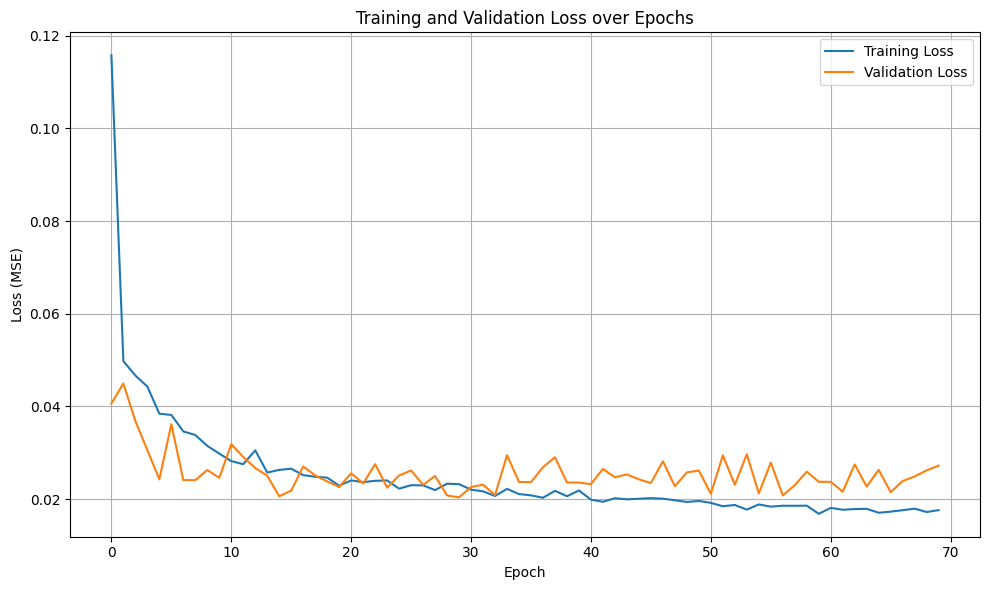

In [7]:
import matplotlib.pyplot as plt

# Plot training and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh data\loss_plot_N.png")
plt.show()

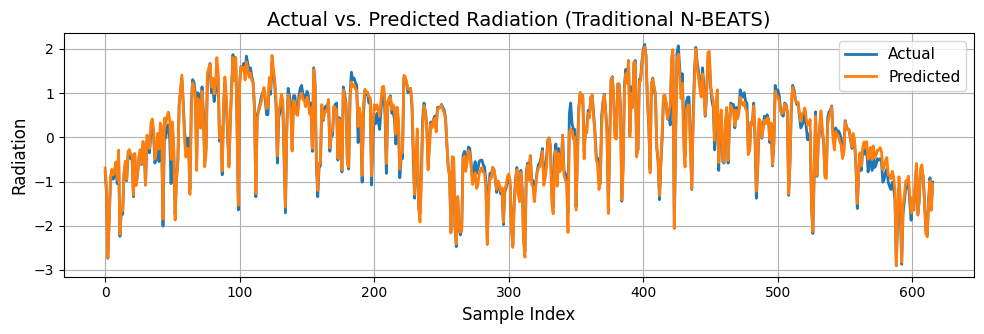

In [5]:
import matplotlib.pyplot as plt

# Set global font styles for publication quality
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'legend.fontsize': 11,
    'figure.titlesize': 14
})

# Create plot
plt.figure(figsize=(10, 3.5))  # Ideal for one-column width (approx 3.5–3.7 in in journals)
plt.plot(y_test_np, label='Actual', linewidth=2)
plt.plot(y_pred_np, label='Predicted', linewidth=2)

plt.title("Actual vs. Predicted Radiation (Traditional N-BEATS)")
plt.xlabel("Sample Index")
plt.ylabel("Radiation")
plt.legend(loc='best')
plt.grid(True)
plt.tight_layout()

# Save high-resolution figure
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\NBEATS\actual_vs_predicted.png", dpi=300, bbox_inches='tight')

plt.show()


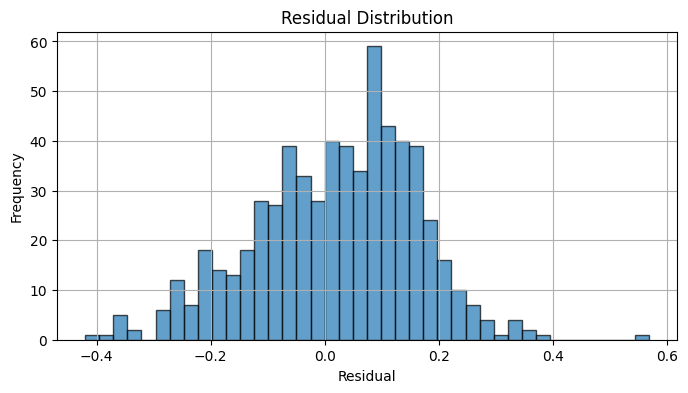

In [9]:
residuals = y_test_np - y_pred_np
plt.figure(figsize=(8, 4))
plt.hist(residuals, bins=40, alpha=0.7, edgecolor='black')
plt.title("Residual Distribution")
plt.xlabel("Residual")
plt.ylabel("Frequency")
plt.grid(True)
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh data\residual_distribution_N.png")
plt.show()

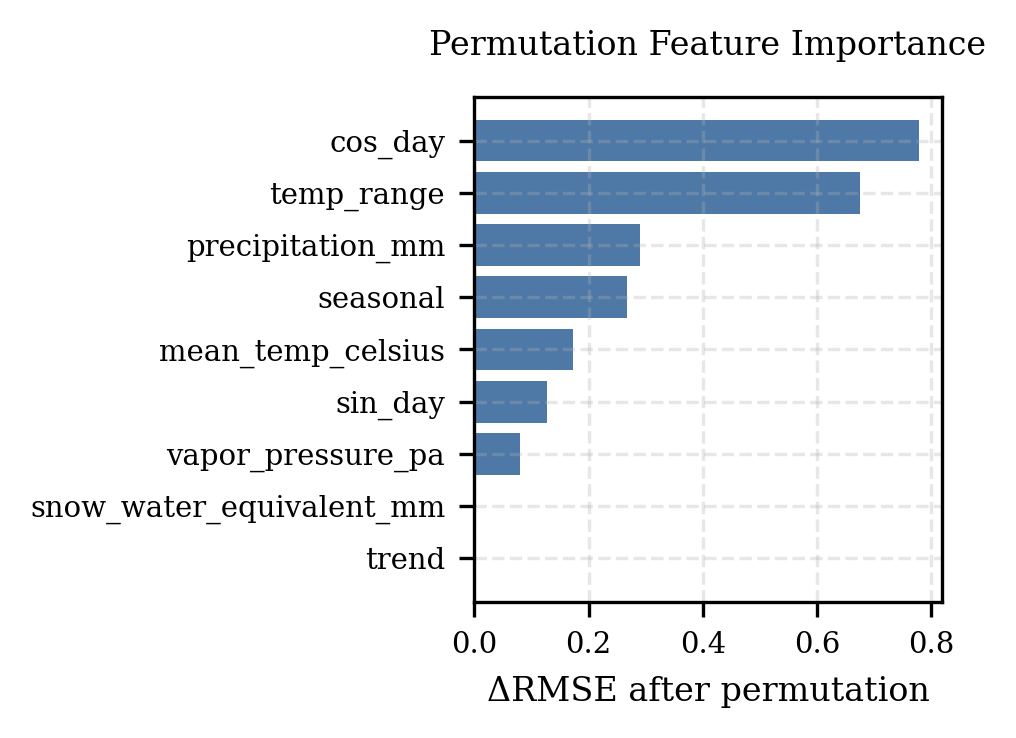

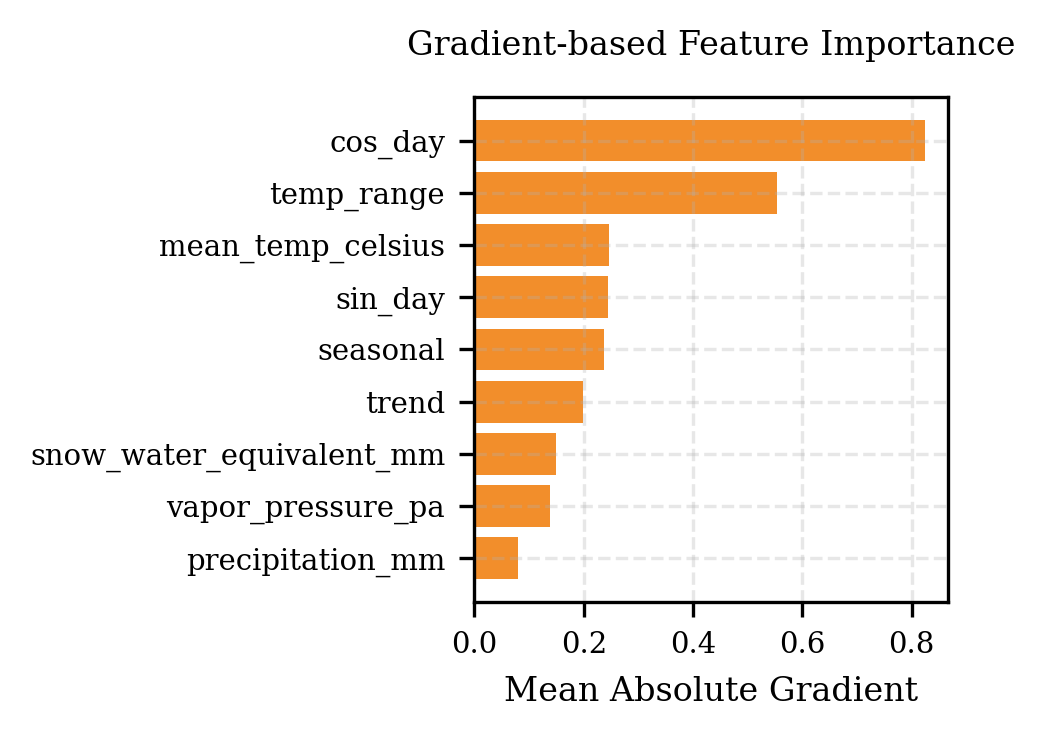

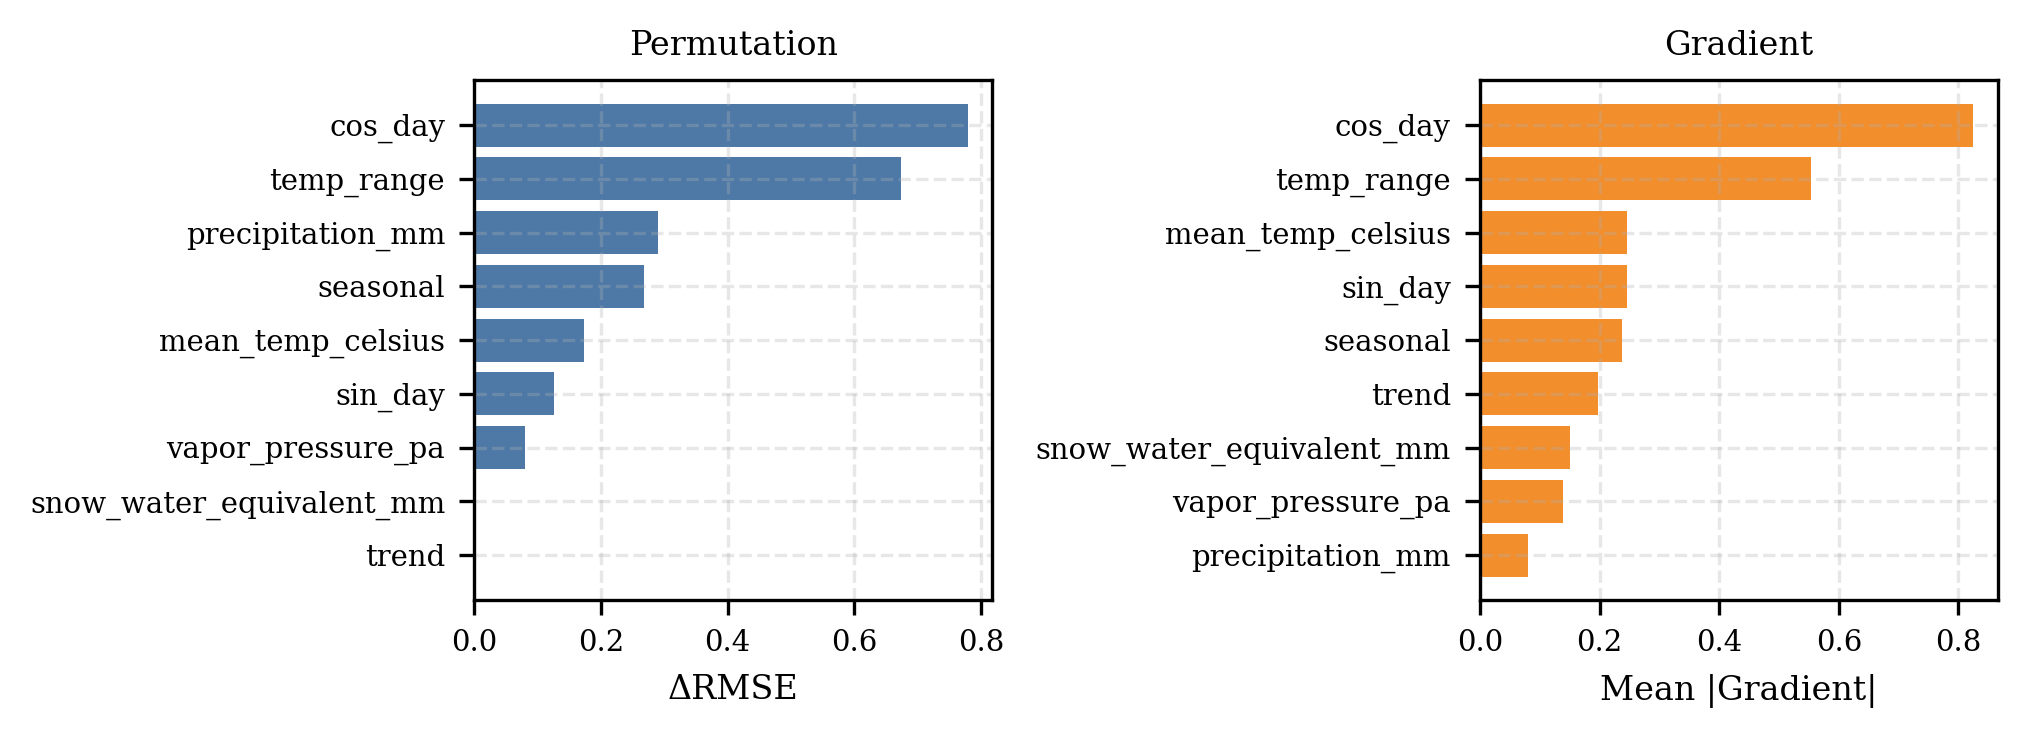

In [4]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from copy import deepcopy
from sklearn.metrics import mean_squared_error

# ---------- PREPARE ----------
model.eval()

# Clone data for safety
X_test_perm = X_test_t.clone()
y_test_true = y_test_t.clone()
base_preds = model(X_test_perm).detach().numpy().flatten()
base_rmse = np.sqrt(mean_squared_error(y_test_true.numpy(), base_preds))

# ---------- PERMUTATION IMPORTANCE ----------
perm_importances = []
feature_names = [
    "trend", "seasonal", "sin_day", "cos_day",
    "mean_temp_celsius", "vapor_pressure_pa", "precipitation_mm",
    "snow_water_equivalent_mm", "temp_range"
]

for i in range(X_test_perm.shape[1]):
    X_permuted = X_test_perm.clone()
    idx = torch.randperm(X_test_perm.size(0))
    X_permuted[:, i] = X_permuted[idx, i]  # Shuffle one column
    perm_preds = model(X_permuted).detach().numpy().flatten()
    perm_rmse = np.sqrt(mean_squared_error(y_test_true.numpy(), perm_preds))
    importance = perm_rmse - base_rmse
    perm_importances.append(importance)

importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance (RMSE Increase)": perm_importances
}).sort_values(by="Importance (RMSE Increase)", ascending=True)

# ---------- GRADIENT-BASED IMPORTANCE ----------
X_test_t.requires_grad = True
grad_importances = torch.zeros(X_test_t.shape[1])

for i in range(X_test_t.shape[0]):
    model.zero_grad()
    output = model(X_test_t[i:i+1])
    output.backward(torch.ones_like(output))
    grad_importances += X_test_t.grad[i].abs().detach()

grad_importances /= X_test_t.shape[0]
grad_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Gradient Importance": grad_importances.numpy()
}).sort_values(by="Gradient Importance", ascending=True)

# ---------- IEEE/Elsevier PLOTTING ----------
mpl.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7,
    "figure.figsize": (3.3, 2.5),
    "figure.dpi": 300,
    "savefig.dpi": 600,
    "axes.grid": True,
    "grid.alpha": 0.3,
    "grid.linestyle": "--"
})

# --- Permutation Plot ---
plt.figure()
plt.barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
plt.xlabel("ΔRMSE after permutation")
plt.title("Permutation Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\NBEATS\permutation_importance.png")
plt.show()

# --- Gradient Plot ---
plt.figure()
plt.barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
plt.xlabel("Mean Absolute Gradient")
plt.title("Gradient-based Feature Importance", pad=10)
plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\NBEATS\gradient_importance.png")
plt.show()

# --- Combined Plot (Optional) ---
fig, ax = plt.subplots(1, 2, figsize=(6.8, 2.5))
ax[0].barh(importance_df["Feature"], importance_df["Importance (RMSE Increase)"], color="#4E79A7")
ax[0].set_title("Permutation", fontsize=8)
ax[0].set_xlabel("ΔRMSE", fontsize=8)

ax[1].barh(grad_importance_df["Feature"], grad_importance_df["Gradient Importance"], color="#F28E2B")
ax[1].set_title("Gradient", fontsize=8)
ax[1].set_xlabel("Mean |Gradient|", fontsize=8)

for a in ax:
    a.tick_params(axis='both', which='major', labelsize=7)
    a.grid(True, linestyle='--', alpha=0.3)

plt.tight_layout()
plt.savefig(r"D:\Projects\quantum forecasting\plots\riyadh\NBEATS\feature_importance_combined.png")
plt.show()
